<div class="alert alert-block alert-success">

# **1.** **Import Libraries**

<div>

In [2]:
# Add the parent directory to the path
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
from algorithms.genetic_algorithm.entities import *
from algorithms.genetic_algorithm.selection import *
from algorithms.genetic_algorithm.crossover import *
from algorithms.genetic_algorithm.mutation import *
from algorithms.genetic_algorithm.genetic_algorithm import *
from algorithms.hill_climbing import *
from algorithms.simulated_annealing import *
from tuning.configurations_tune import *
from tuning.parameters_tune import *

from utils import *

<div class="alert alert-block alert-success">

# **2.** **Runs**

<div>

## **2.1** Fixed Parameters

In [3]:
POP_SIZE = 50
N_GENERATIONS = 100
elitism = True
maximization = True
n_runs=30

selection_base = tournament_selection
crossover = pmx_crossover
mutation_base = n_swap_mutation

## **2.2** Run GA Configurations

### **2.2.1** Tournament Selection

In [2]:
crossover_operators = [pmx_crossover, fitness_based_slot_crossover]
mutation_operators = [n_swap_mutation, scramble_mutation, prime_slot_swap_mutation, preserve_best_slots_mutation]
selection_methods = [tournament_selection]

configurations= list(product(crossover_operators, mutation_operators, selection_methods))

In [ ]:
results_tournament = grid_search(configurations=configurations, mode='detailed', n_runs=1, verbose_ga=False)

In [ ]:
long_format_rows = []

for col in results_tournament.columns:
    parts = col.split(" | ")
    selection = parts[0].split(": ")[1]
    crossover = parts[1].split(": ")[1]
    mutation = parts[2].split(": ")[1]

    # Get raw data from cell
    raw = results_tournament[col].dropna().values[0]

    # Decode JSON string if needed
    if isinstance(raw, str):
        raw = json.loads(raw)

    fitness_history = raw[0] if isinstance(raw, list) and len(raw) == 1 else raw

    long_format_rows.append({
        "Selection": selection,
        "Crossover": crossover,
        "Mutation": mutation,
        "Run": 1,
        "Fitness_History": fitness_history,
        "Config": col
    })

results_tournament = pd.DataFrame(long_format_rows)

In [16]:
results_tournament.to_csv("results_tournament_selection.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

### **2.2.2** Ranking Selection

In [ ]:
crossover_operators = [pmx_crossover, fitness_based_slot_crossover]
mutation_operators = [n_swap_mutation, scramble_mutation, prime_slot_swap_mutation, preserve_best_slots_mutation]
selection_methods = [ranking_selection]

configurations= list(product(crossover_operators, mutation_operators, selection_methods))

In [ ]:
results_ranking = grid_search(configurations=configurations, mode='detailed', n_runs=30, verbose_ga=False)

In [ ]:
long_format_rows = []

for col in results_ranking.columns:
    parts = col.split(" | ")
    selection = parts[0].split(": ")[1]
    crossover = parts[1].split(": ")[1]
    mutation = parts[2].split(": ")[1]

    # Get raw data from cell
    raw = results_ranking[col].dropna().values[0]

    # Decode JSON string if needed
    if isinstance(raw, str):
        raw = json.loads(raw)

    fitness_history = raw[0] if isinstance(raw, list) and len(raw) == 1 else raw

    long_format_rows.append({
        "Selection": selection,
        "Crossover": crossover,
        "Mutation": mutation,
        "Run": 1,
        "Fitness_History": fitness_history,
        "Config": col
    })

results_ranking = pd.DataFrame(long_format_rows)

In [ ]:
results_ranking.to_csv("results_ranking_selection.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

### **2.2.3** Fitness Proportionate Selection

In [ ]:
crossover_operators = [pmx_crossover, fitness_based_slot_crossover]
mutation_operators = [n_swap_mutation, scramble_mutation, prime_slot_swap_mutation, preserve_best_slots_mutation]
selection_methods = [fitness_proportionate_selection]

configurations= list(product(crossover_operators, mutation_operators, selection_methods))

In [ ]:
results_fit_prop = grid_search(configurations=configurations, mode='detailed', n_runs=30, verbose_ga=False)

In [ ]:
long_format_rows = []

for col in results_fit_prop.columns:
    parts = col.split(" | ")
    selection = parts[0].split(": ")[1]
    crossover = parts[1].split(": ")[1]
    mutation = parts[2].split(": ")[1]

    # Get raw data from cell
    raw = results_fit_prop[col].dropna().values[0]

    # Decode JSON string if needed
    if isinstance(raw, str):
        raw = json.loads(raw)

    fitness_history = raw[0] if isinstance(raw, list) and len(raw) == 1 else raw

    long_format_rows.append({
        "Selection": selection,
        "Crossover": crossover,
        "Mutation": mutation,
        "Run": 1,
        "Fitness_History": fitness_history,
        "Config": col
    })

results_fit_prop = pd.DataFrame(long_format_rows)

In [ ]:
results_fit_prop.to_csv("results_fit_prop_selection.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

### **2.2.4** Concatenate DataFrames

In [ ]:
results = pd.concat([results_fit_prop, results_tournament, results_ranking], ignore_index=True)

In [ ]:
results.to_csv("final_results.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

## **2.3** Run SA e HC

In [ ]:
initial_solution = Individual(
    mutation_function=n_swap_mutation,
    crossover_function=pmx_crossover
)

In [ ]:
hc_best_fitnesses = []
sa_best_fitnesses =[]
ga_best_fitnesses = []

for run_nr in range(30):
    hc_best_solution = hill_climbing(
        initial_solution=initial_solution,
        maximization=False
    )
    sa_best_solution = simulated_annealing(
        initial_solution=initial_solution,
        maximization=False,
        C=1,
        L=10,
        H=0.1,
        max_iter=100
    )
    ga_best_solution, _ = genetic_algorithm(
        initial_solution,
        max_gen=100,
        selection_algorithm=fitness_proportionate_selection,
        xo_prob=0.9,
        mut_prob=0.1,
        elitism=True
    )

    hc_best_fitnesses.append(hc_best_solution.fitness())
    sa_best_fitnesses.append(sa_best_solution.fitness())
    ga_best_fitnesses.append(ga_best_solution.fitness())

In [ ]:
df = pd.DataFrame({
    'value': hc_best_fitnesses + sa_best_fitnesses + ga_best_fitnesses,
    'group': ['HC'] * len(hc_best_fitnesses) + ['SA'] * len(sa_best_fitnesses) + ['GA'] * len(ga_best_fitnesses)
})

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='group', y='value', data=df, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Comparison of HC, SA and GA')
plt.xlabel('Algorithms')
plt.ylabel('Fitness of best found individual')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## **2.4** Run GA Hyperparameter Tuning

In [3]:
results_hyperparameter = random_search(mode='detailed', verbose_ga=False)

Configuration 1: xo_prob=0.91, mut_prob=0.32, n_swaps=3, tournament_size=4
  Run 1/30
  Run 2/30
  Run 3/30
  Run 4/30
  Run 5/30
  Run 6/30
  Run 7/30
  Run 8/30
  Run 9/30
  Run 10/30
  Run 11/30
  Run 12/30
  Run 13/30
  Run 14/30
  Run 15/30
  Run 16/30
  Run 17/30
  Run 18/30
  Run 19/30
  Run 20/30
  Run 21/30
  Run 22/30
  Run 23/30
  Run 24/30
  Run 25/30
  Run 26/30
  Run 27/30
  Run 28/30
  Run 29/30
  Run 30/30
Configuration 2: xo_prob=0.65, mut_prob=0.25, n_swaps=3, tournament_size=8
  Run 1/30
  Run 2/30
  Run 3/30
  Run 4/30
  Run 5/30
  Run 6/30
  Run 7/30
  Run 8/30
  Run 9/30
  Run 10/30
  Run 11/30
  Run 12/30
  Run 13/30
  Run 14/30
  Run 15/30
  Run 16/30
  Run 17/30
  Run 18/30
  Run 19/30
  Run 20/30
  Run 21/30
  Run 22/30
  Run 23/30
  Run 24/30
  Run 25/30
  Run 26/30
  Run 27/30
  Run 28/30
  Run 29/30
  Run 30/30
Configuration 3: xo_prob=0.98, mut_prob=0.36, n_swaps=4, tournament_size=3
  Run 1/30
  Run 2/30
  Run 3/30
  Run 4/30
  Run 5/30
  Run 6/30
  Run 7

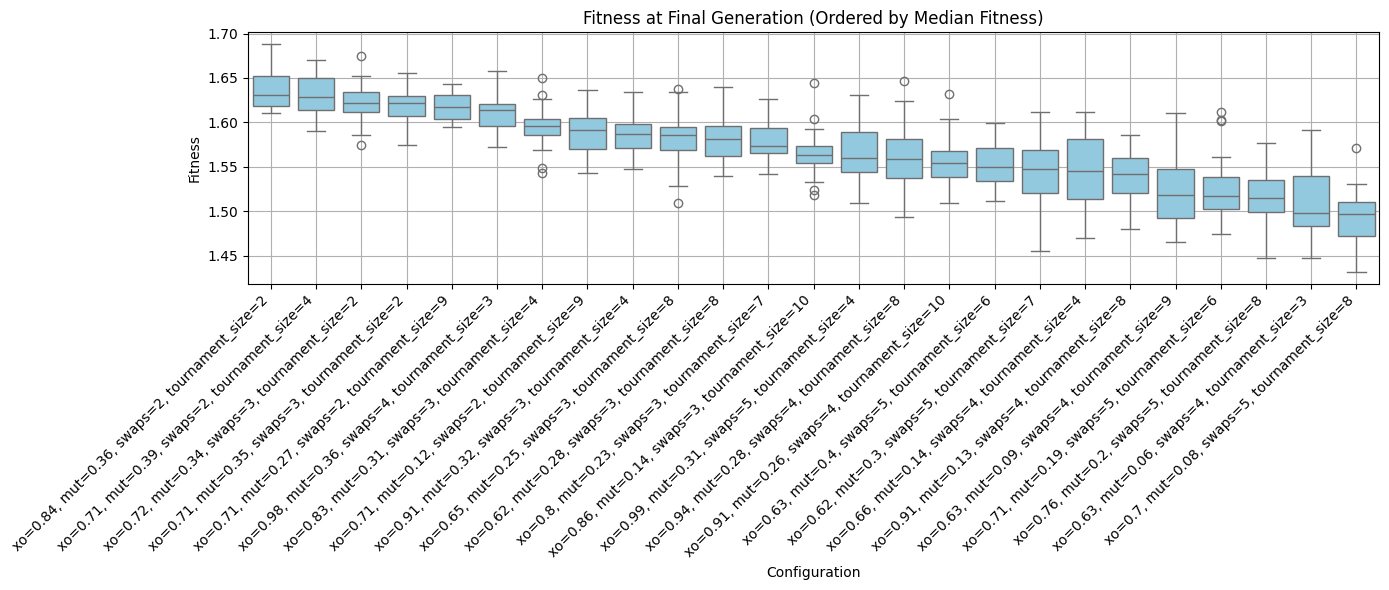

In [ ]:
# Parse JSON strings to lists
results_hyperparameter['fitness_history'] = results_hyperparameter['fitness_history'].apply(json.loads)


# Store fitness values at the final generation for each config
final_gen_fitness = []

for idx, row in results_hyperparameter.iterrows():
    config_name = f"xo={row['xo_prob']}, mut={row['mut_prob']}, swaps={row['n_swaps']}, tournament_size={row['tournament_size']}"
    run_histories = row['fitness_history']  # Already a list of 30 runs
    final_gen_index = len(run_histories[0]) - 1  # Last generation
    
    for run_id, run in enumerate(run_histories):
        final_gen_fitness.append({
            'Configuration': config_name,
            'Fitness': run[final_gen_index],
            'Run': f'Run {run_id + 1}'
        })

# Create DataFrame
df_final = pd.DataFrame(final_gen_fitness)

# Compute median fitness per configuration and order
median_order = df_final.groupby("Configuration")["Fitness"].median().sort_values(ascending=False).index

# Plot with custom order
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_final, x='Configuration', y='Fitness', order=median_order, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Fitness at Final Generation (Ordered by Median Fitness)")
plt.tight_layout()
plt.grid(True)
plt.show()



In [5]:
results_hyperparameter.to_csv("results_hyperparameter.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

## **2.5** Adaptive Genetic Algorithm with Dynamic Mutation, Selection Pressure and Partial Replacement

- **n_swaps** should be increased when fitness stagnates to inject more mutation/exploration. So we use min(n_swaps + 1, max_swaps) to cap it and avoid overly destructive mutation.
- **tournament_size** should be decreased to reduce selection pressure and increase diversity (allow weaker individuals a better chance to survive). So we use max(tournament_size - 1, min_tournament) to floor it and avoid completely random selection.

In [4]:
params = {
    "n_swaps": 2,
    "max_n_swaps": 8,
    "tournament_size": 4,
    "min_tournament_size": 2,
    "mutation_base": n_swap_mutation,
    "selection_base": tournament_selection,
    "mutation_args": ["n_swaps"],
    "selection_args": ["tournament_size"],
    "adapt_keys": ["n_swaps", "tournament_size"],
    "adapt_directions": {"n_swaps": "up", "tournament_size": "down"}
}

In [5]:
xo_prob = 0.84
mut_prob = 0.36

In [6]:
# Initial wrapped functions
mutation = partial(n_swap_mutation, n_swaps=params["n_swaps"])
selection = partial(tournament_selection, tournament_size=params["tournament_size"])

In [ ]:
fitness_histories = {}

scenarios = [
    ("Normal", False, False, None, None),
    ("Normal + Diversify", False, True, 1e-3, 10),
    ("Soft", True, False, 1e-3, 10),
    ("Soft + Diversify", True, True, 1e-3, 10),
    ("Aggressive", True, False, 1e-1, 10),
    ("Aggressive + Diversify", True, True, 1e-1, 10),
    ("Very Aggressive", True, False, 2e-1, 10),
    ("Very Aggressive + Diversify", True, True, 2e-1, 10)
]

for scenario_name, adapt_on_stable, diversify_on_plateau, epsilon, window in scenarios:
    print(f"------ {scenario_name} ------")
    history_runs = []

    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        population = Population(
            population_size=POP_SIZE,
            crossover_function=pmx_crossover,
            mutation_function=mutation
        )

        kwargs = dict(
            initial_population=deepcopy(population),
            max_gen=N_GENERATIONS,
            selection_algorithm=selection,
            maximization=True,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=True,
            verbose_ga="minimal",
            adapt_on_stable=adapt_on_stable,
            diversify_on_plateau=diversify_on_plateau
        )

        if adapt_on_stable:
            kwargs["params"] = deepcopy(params)
            kwargs["stability_window"] = window
            kwargs["stability_epsilon"] = epsilon

        fitness_history, _ = genetic_algorithm(**kwargs)
        history_runs.append(fitness_history)

    fitness_histories[scenario_name] = pd.DataFrame(history_runs).T

------ Normal ------
Run 1/30

-------------- Generation: 1 --------------
Best fitness: 1.2187

-------------- Generation: 2 --------------
Best fitness: 1.2294

-------------- Generation: 3 --------------
Best fitness: 1.2839

-------------- Generation: 4 --------------
Best fitness: 1.3301

-------------- Generation: 5 --------------
Best fitness: 1.3537

-------------- Generation: 6 --------------
Best fitness: 1.3866

-------------- Generation: 7 --------------
Best fitness: 1.4265

-------------- Generation: 8 --------------
Best fitness: 1.4407

-------------- Generation: 9 --------------
Best fitness: 1.4551

-------------- Generation: 10 --------------
Best fitness: 1.4551

-------------- Generation: 11 --------------
Best fitness: 1.4572

-------------- Generation: 12 --------------
Best fitness: 1.4794

-------------- Generation: 13 --------------
Best fitness: 1.4794

-------------- Generation: 14 --------------
Best fitness: 1.4794

-------------- Generation: 15 ----------

In [21]:
all_fitness_df = pd.concat(fitness_histories, axis=1)
all_fitness_df.to_csv("results/ga/fitness_adaptive_ga.csv")

## **2.6** Run Final Solution

In [8]:
n_swaps = 2
tournament_size = 2
xo_prob = 0.84
mut_prob = 0.36

In [ ]:
best_solution = None
best_fitness = float('-inf') if maximization else float('inf')
all_histories = []

for run in range(30):
    print(f"\n--- RUN {run + 1}/30 ---")
    
    # Re-initialize population for each run
    initial_population = Population(
        population_size=POP_SIZE,
        crossover_function=crossover,
        mutation_function=mutation
    )

    # Run GA
    fitness_history, final_solution = genetic_algorithm(
        initial_population=initial_population,
        max_gen=N_GENERATIONS,
        selection_algorithm=selection,
        maximization=maximization,
        xo_prob=xo_prob,
        mut_prob=mut_prob,
        elitism=elitism,
        verbose_ga="minimal",
        diversify_on_plateau=True,
        stability_epsilon=1e-3,
        stability_window=10
    )

    all_histories.append(fitness_history)

    # Get fitness of this run's final best solution
    current_fitness = final_solution.fitness()

    # Keep best across runs
    if (maximization and current_fitness > best_fitness) or (not maximization and current_fitness < best_fitness):
        best_solution = deepcopy(final_solution)
        best_fitness = current_fitness

# Result
print("\n=== BEST OVERALL INDIVIDUAL ===")
print(best_solution)


--- RUN 1/30 ---

-------------- Generation: 1 --------------
Best fitness: 1.3320

-------------- Generation: 2 --------------
Best fitness: 1.3441

-------------- Generation: 3 --------------
Best fitness: 1.4470

-------------- Generation: 4 --------------
Best fitness: 1.4591

-------------- Generation: 5 --------------
Best fitness: 1.4749

-------------- Generation: 6 --------------
Best fitness: 1.4970

-------------- Generation: 7 --------------
Best fitness: 1.4970

-------------- Generation: 8 --------------
Best fitness: 1.5099

-------------- Generation: 9 --------------
Best fitness: 1.5199

-------------- Generation: 10 --------------
Best fitness: 1.5199

-------------- Generation: 11 --------------
Best fitness: 1.5199

-------------- Generation: 12 --------------
Best fitness: 1.5199

-------------- Generation: 13 --------------
Best fitness: 1.5199

-------------- Generation: 14 --------------
Best fitness: 1.5199

-------------- Generation: 15 --------------
Best fi

In [6]:
print(best_solution.print_artist_details())

Fitness: 1.6608
Slot 1: ['Cosmic Frequency (Genre: Rock, Popularity: 53)', 'The Sonic Drifters (Genre: Rock, Popularity: 88)', 'The Polyrhythm Syndicate (Genre: Jazz, Popularity: 66)', 'Parallel Dimension (Genre: Electronic, Popularity: 58)', 'Harmonic Dissonance (Genre: Classical, Popularity: 96)']
Slot 2: ['Static Mirage (Genre: Rock, Popularity: 94)', 'The Jazz Nomads (Genre: Jazz, Popularity: 64)', 'Astral Tide (Genre: Electronic, Popularity: 69)', 'Golden Ember (Genre: Rock, Popularity: 61)', 'Mystic Rhythms (Genre: Classical, Popularity: 78)']
Slot 3: ['Shadow Cadence (Genre: Jazz, Popularity: 66)', 'Crimson Harmony (Genre: Classical, Popularity: 20)', 'Aurora Skies (Genre: Pop, Popularity: 75)', 'Synthwave Saints (Genre: Rock, Popularity: 94)', 'Solar Flare (Genre: Electronic, Popularity: 78)']
Slot 4: ['Nightfall Sonata (Genre: Classical, Popularity: 84)', 'Hypnotic Echoes (Genre: Rock, Popularity: 77)', 'Echo Chamber (Genre: Electronic, Popularity: 98)', 'Velvet Pulse (Genre: 